In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import os
import pint
import json
import pprint

from pygama.flow import DataLoader
from pygama.flow import FileDB
from pygama.lgdo.lh5_store import LH5Store
from pygama.lgdo import ls, Table, WaveformTable
from pygama.dsp import build_dsp

# Setup FileDB and DataLoader

In [2]:
# Run this to perform a scan of all files and create a FileDB from scratch, then save it to disk
fdb = FileDB(config="metadata/dataloader_configs/cage_filedb_config.json")
fdb.scan_tables_columns()
fdb.to_disk("cage_filedb.lh5", "o")

Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run385_cyc2527_raw.lh5
Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run385_cyc2528_raw.lh5
Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run386_cyc2529_raw.lh5
Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run386_cyc2530_raw.lh5
Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run386_cyc2531_raw.lh5
Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run386_cyc2532_raw.lh5
Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run387_cyc2533_raw.lh5
Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run387_cyc2534_raw.lh5
Cannot find 'ORSIS3302DecoderForEnergy/raw' in /global/cfs/cdirs

In [ ]:
# Run this to load an existing FileDB from disk
fdb = FileDB("cage_filedb.lh5")

In [3]:
dl = DataLoader(config="metadata/dataloader_configs/cage_loader_config.json",
                filedb=fdb)

In [4]:
fdb.df['raw_tables']

0       [0]
1       [0]
2       [0]
3       [0]
4       [0]
       ... 
3863    [0]
3864    [0]
3865    [0]
3866    [0]
3867    [0]
Name: raw_tables, Length: 3868, dtype: object

In [5]:
cyc = 3207
dl.reset()
dl.set_files(f"cycle == {cyc}")
dl.set_output(fmt="pd.DataFrame", columns=["energy"])
el = dl.build_entry_list(save_output_columns=True)
data = dl.load(el)

Building entry list: 100%|██████████| 1/1 [00:00<00:00, 4544.21 keys/s, key=3207]

Below you can check the spectrum to make sure it looks okay, then you can zoom in and pick out where the 1460 kev peak is. 

In [ ]:
%matplotlib widget

In [ ]:
%matplotlib inline

Text(0, 0.5, 'count')

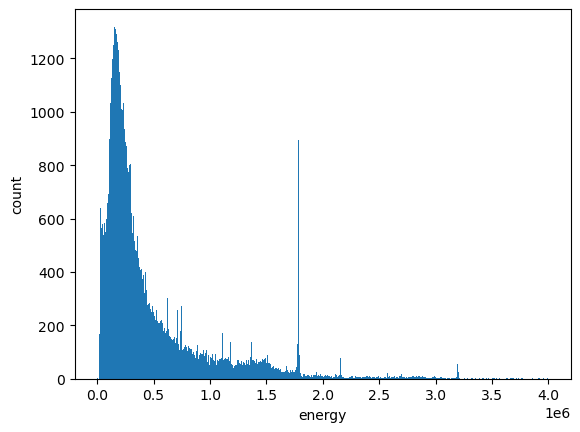

In [6]:
plt.figure()
#plt.yscale('log')
plt.hist(data['energy'], bins = np.linspace(0, 4e6, 1000))
plt.xlabel('energy')
plt.ylabel('count')

Text(0, 0.5, 'count')

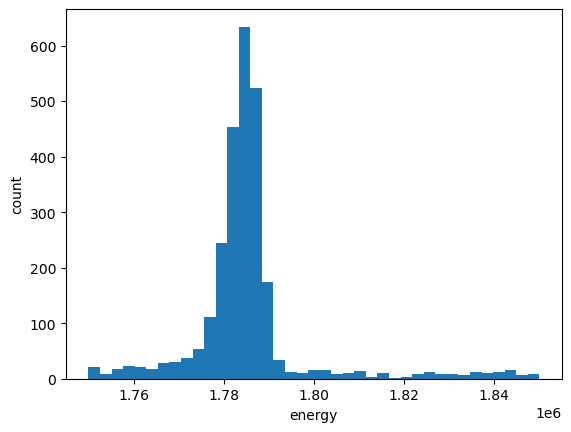

In [12]:
plt.figure()
plt.hist(data['energy'], bins = np.linspace(1.75e6, 1.85e6, 40))
plt.xlabel('energy')
plt.ylabel('count')

In [13]:
# input the low and high ends of the 1460 kev peak here
elo = 1.77e6
ehi = 1.80e6

# Load 1460 keV Waveforms

In [14]:
dl.reset()
dl.set_files(f"cycle == {cyc}")
dl.set_cuts({"hit": f"energy > {elo} and energy < {ehi}"})
dl.set_output(columns=["waveform"])
wfs = dl.load()

Building entry list: 100%|██████████| 1/1 [00:00<00:00, 4396.55 keys/s, key=3207]

In [16]:
wfs['waveform']['dt'].attrs

{'datatype': 'array<1>{real}', 'units': 'ns'}

In [18]:
# Save waveforms to a temporary "raw" file
raw_file = "1460raw_temp.lh5"
# sto.write_object(obj=wfs["energy"], name="energy", lh5_file=raw_file, group="raw")
sto = LH5Store()
sto.write_object(obj=wfs, name="40K", lh5_file=raw_file, wo_mode="of")

In [19]:
ureg = pint.UnitRegistry()
per_unit = 1/(wfs['waveform']['dt'].nda[0] * ureg(wfs['waveform']['dt'].attrs['units']).units)
per_us = per_unit.to("1/us")
print(per_unit)
print(per_us)

0.1 / nanosecond
100.0 / microsecond


# First Pass DSP
We run the DSP once to find a reasonable guess for `pz_tau` and bins for our energy histogram

In [20]:
dsp_db = {
    "40K": {
        "etrap": {
            "rise": "8*us",
            "flat": "2*us"
        },
        "pz": {
            "tau": "70*us"
        },
        "dcr_trap": {
            "rise": "8*us",
            "flat": "2*us"
        },
        "ctc": {
            "alpha": 1
        }
    }
}
dsp_config = {
  "outputs": [
    "trapEmax", "lt_slope"
  ],
  "processors":{
    "bl, bl_sig, bl_slope, bl_intercept":{
      "function": "linear_slope_fit",
      "module": "pygama.dsp.processors",
      "args" : ["waveform[0: 3500]", "bl","bl_sig", "bl_slope","bl_intercept"],
      "unit": ["ADC","ADC","ADC","ADC"]
    },
    "wf_blsub":{
      "function": "subtract",
      "module": "numpy",
      "args": ["waveform", "bl", "wf_blsub"],
      "prereqs": ["waveform", "bl"],
      "unit": "ADC"
    },
    "wf_logtail": {
      "function": "log",
      "module": "numpy",
      "args": ["wf_blsub[4250:8000]", "wf_logtail"],
      "unit": "ADC",
      "prereqs": ["wf_blsub"]
    },
    "lt_mean, lt_sig, lt_slope, lt_int": {
        "function": "linear_slope_fit",
        "module": "pygama.dsp.processors",
        "args": ["wf_logtail", "lt_mean", "lt_sig", "lt_slope", "lt_int"],
        "unit": ["ADC", "ADC", "ADC", "ADC"],
        "prereqs": ["wf_logtail"]
    },
    "wf_pz": {
      "function": "pole_zero",
      "module": "pygama.dsp.processors",
      "args": ["wf_blsub", "db.pz.tau", "wf_pz"],
      "prereqs": ["wf_blsub"],
      "unit": "ADC",
    },
    "wf_etrap": {
      "function": "trap_norm",
      "module": "pygama.dsp.processors",
      "prereqs": ["wf_pz"],
      "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
      "unit": "ADC"
    },
    "trapEmax": {
      "function": "amax",
      "module": "numpy",
      "args": ["wf_etrap", 1, "trapEmax"],
      "kwargs": {"signature":"(n),()->()", "types":["fi->f"]},
      "unit": "ADC",
      "prereqs": ["wf_etrap"]
    },
    "trapEmax_ctc": {
      "function": "add",
      "module": "numpy",
      "args": ["trapEmax", "db.ctc.alpha*dcr", "trapEmax_ctc"],
      "unit": "ADC",
      "prereqs": ["trapEmax", "dcr"]
    },
    "tp_min, tp_max, wf_min, wf_max":{
      "function": "min_max",
      "module": "pygama.dsp.processors",
      "args": ["wf_blsub", "tp_min", "tp_max", "wf_min", "wf_max"],
      "unit": ["ns","ns","ADC", "ADC"],
      "prereqs": ["wf_blsub"]
    },
    "pz_mean, pz_sig, pz_slope, pz_int": {
        "function": "linear_slope_fit",
        "module": "pygama.dsp.processors",
        "args": ["wf_pz[5750:8000]", "pz_mean", "pz_sig", "pz_slope", "pz_int"],
        "unit": ["ADC", "ADC", "ADC", "ADC"],
        "prereqs": ["wf_pz"]
    },
    "wf_dcr_trap": {
        "function": "trap_norm",
        "module": "pygama.dsp.processors",
        "args": ["wf_pz", "db.dcr_trap.rise", "db.dcr_trap.flat", "wf_dcr_trap"],
        "defaults" : {"db.dcr_trap.rise":"7*us", "db.dcr_trap.flat":"20*us"},
        "unit": "ADC",
        "prereqs": ["wf_pz"]
    },
    "dcr": {
        "function": "fixed_time_pickoff",
        "module": "pygama.dsp.processors",
        "args": ["wf_dcr_trap", "db.dcr.ftp", "i", "dcr"],
        "defaults" : {"db.dcr.ftp" : "80*us"},
        "unit": "ADC",
        "prereqs": ["wf_dcr_trap"]
    }
  }
}


In [21]:
dsp_file = "1460dsp_temp.lh5"
build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r', n_max=100)

In [22]:
pk_table, _ = sto.read_object("40K", dsp_file)
pk_df = pk_table.get_dataframe()

In [23]:
lt_tau = 1 / (pk_df['lt_slope'].mean()*per_us.magnitude) # ADC/sample * samples/us = ADC/us
tau_range = -np.arange(lt_tau - 1, lt_tau + 1, .2)

In [24]:
emed = pk_df.median()['trapEmax']
ebins = np.linspace(emed - 0.02*emed, emed + 0.02*emed, 20)

In [25]:
rise_range = np.arange(5, 15)
dcrrise_range = np.arange(2, 5)
dcrflat_range = np.arange(18, 21)
alpha_range = np.linspace(0.5, 15, 10)

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([3093.52073242, 3100.16631939, 3106.81190635, ..., 3206.49571083,
        3213.1412978 , 3219.78688477]),
 [<matplotlib.patches.Polygon at 0x7f2a14cfb400>])

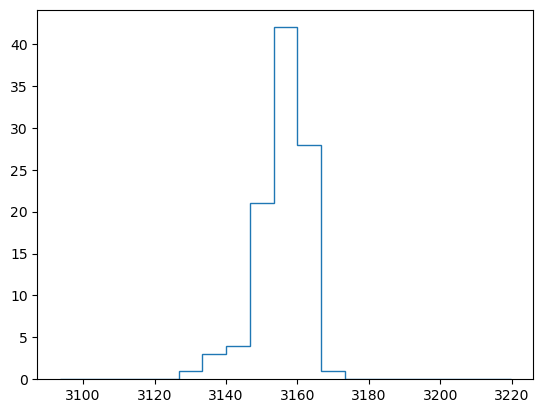

In [26]:
#plt.hist(pk_df['trapEmax_ctc'], bins=ebins, histtype='step')
plt.hist(pk_df['trapEmax'], bins=ebins, histtype='step')

In [27]:
print(lt_tau)
print(tau_range)
print(rise_range)
print(dcrrise_range)
print(dcrflat_range)
print(ebins)
print(alpha_range)

-64.48161905690468
[65.48161906 65.28161906 65.08161906 64.88161906 64.68161906 64.48161906
 64.28161906 64.08161906 63.88161906 63.68161906]
[ 5  6  7  8  9 10 11 12 13 14]
[2 3 4]
[18 19 20]
[3093.52073242 3100.16631939 3106.81190635 ... 3206.49571083 3213.1412978
 3219.78688477]
[ 0.5         2.11111111  3.72222222  5.33333333  6.94444444  8.55555556
 10.16666667 11.77777778 13.38888889 15.        ]


# DSP Loop

In [28]:
dsp_config["outputs"] = ["pz_slope", "trapEmax", "dcr", "trapEmax_ctc"]
dsp_config["processors"].pop("wf_logtail")
dsp_config["processors"].pop("lt_mean, lt_sig, lt_slope, lt_int")

{'function': 'linear_slope_fit',
 'module': 'pygama.dsp.processors',
 'args': ['wf_logtail', 'lt_mean', 'lt_sig', 'lt_slope', 'lt_int'],
 'unit': ['ADC', 'ADC', 'ADC', 'ADC'],
 'prereqs': ['wf_logtail']}

## Pole Zero Loop

Here we are finding the optimum time constant for the decay of the tail, determined by which one gives the flattest slope of the tail once pole-zero corrected

In [37]:
results = None
for tau in tau_range:
    dsp_db["40K"]["pz"]["tau"] = str(tau) + " * us"
        
    dsp_file = "1460dsp_temp.lh5"
    build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r', n_max=20)
    
    pk_table, _ = sto.read_object("40K", dsp_file)
    res = pd.DataFrame({
        "tau": [tau],
        "pz_slope_avg": [np.nanmean(np.abs(pk_table['pz_slope'].nda))]
    })
    if results is None:
        results = res
    else:
        results = pd.concat([results, res], ignore_index=True)
print(results)

         tau  pz_slope_avg
0  65.200000      0.002622
1  65.266667      0.002396
2  65.333333      0.002175
3  65.400000      0.001954
4  65.466667      0.001782
5  65.533333      0.001703
6  65.600000      0.001657
7  65.666667      0.001630
8  65.733333      0.001692
9  65.800000      0.001757


If the best result is at the edge of the range, reset `tau_range` to explore more values, and run the above loop again

In [36]:
tau_range = np.linspace(65.2, 65.8, 10)

Set the DB value to the best tau we found and then plot `wf_pz` to look at the tails

In [38]:
tau = results.abs().sort_values("pz_slope_avg").iloc[0]['tau']
print(tau)
dsp_db["40K"]["pz"]["tau"] = str(tau) + "* us"

65.66666666666667


In [ ]:
dsp_config["outputs"].append("wf_pz")
build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')
pk_table, _ = sto.read_object("40K", dsp_file)
plt.figure()
for wf in pk_table['wf_pz']['values'].nda:
    plt.plot(wf[4250:])
dsp_config["outputs"] = dsp_config["outputs"][:-1]

## Energy Trap Loop

We vary the `rise` parameter in the energy trapezoid to find which one gives the highest peak for the 1460 keV line. 

In [41]:
results = None
for rise in rise_range:
    dsp_db["40K"]["etrap"]["rise"] = str(rise) + " * us"
        
    dsp_file = "1460dsp_temp.lh5"
    build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')
    
    pk_table, _ = sto.read_object("40K", dsp_file)
    
    # These lines will plot each energy histogram
    #plt.figure()
    #plt.yscale('log')
    #ehist, _, _ = plt.hist(pk_table['trapEmax'].nda, bins = np.linspace(3300, 3600, 50), label=rise)
    #plt.legend()
    
    # This one just runs and tells the answer
    ehist, _ = np.histogram(pk_table['trapEmax'].nda, bins = ebins)
    
    res = pd.DataFrame({
        "rise": [rise],
        "peak_height": [np.max(ehist)]
    })
    if results is None:
        results = res
    else:
        results = pd.concat([results, res], ignore_index=True)
print(results)

    rise  peak_height
0      1          498
1      2          741
2      3          915
3      4          973
4      5         1071
5      6         1025
6      7          991
7      8         1139
8      9         1020
9     10         1134
10    11         1190
11    12          937
12    13         1163
13    14         1206
14    15         1047
15    16         1015
16    17         1125


In [40]:
rise_range = np.arange(1, 18)

Text(0, 0.5, 'peak height')

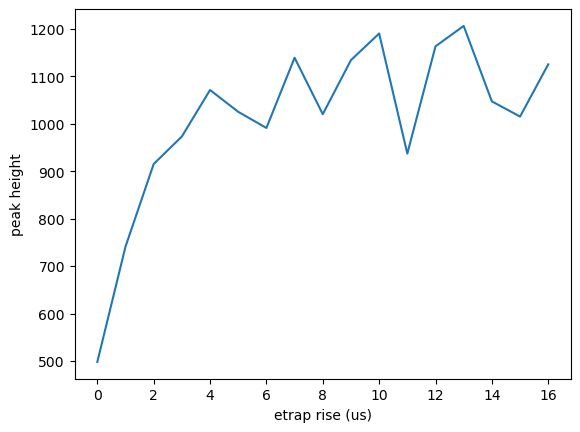

In [42]:
plt.figure()
plt.plot(results["peak_height"])
plt.xlabel("etrap rise (us)")
plt.ylabel("peak height")

In [43]:
rise = results.abs().sort_values("peak_height").iloc[-1]['rise']
print(rise)
dsp_db["40K"]["etrap"]["rise"] = str(rise) + "* us"

14


## DCR Loop

We do a grid-search on both the `rise` and `flat` parameters for the DCR trapezoid that give us a DCR centered around zero.

In [47]:
results = None
for rise in dcrrise_range:
    for flat in dcrflat_range:
        dsp_db["40K"]["dcr_trap"]["rise"] = str(rise) + " * us"
        dsp_db["40K"]["dcr_trap"]["flat"] = str(flat) + " * us"

        dsp_file = "1460dsp_temp.lh5"
        build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')

        pk_table, _ = sto.read_object("40K", dsp_file)

        res = pd.DataFrame({
            "rise": [rise],
            "flat": [flat],
            "dcr_mean": [np.abs(np.mean(pk_table['dcr'].nda))]
        })
        if results is None:
            results = res
        else:
            results = pd.concat([results, res], ignore_index=True)
print(results)

    rise   flat  dcr_mean
0   3.75  19.75  1.542071
1   3.75  20.00  1.295285
2   3.75  20.25  1.042691
3   3.75  20.50  0.768694
4   4.00  19.75  1.068663
5   4.00  20.00  0.807321
6   4.00  20.25  0.523754
7   4.00  20.50  0.226272
8   4.25  19.75  0.571634
9   4.25  20.00  0.276961
10  4.25  20.25  0.024409
11  4.25  20.50  0.338620
12  4.50  19.75  0.029111
13  4.50  20.00  0.278061
14  4.50  20.25  0.605579
15  4.50  20.50  0.946343


If the best result is at the edge of the range, reset `dcrrise_range` and `dcrflat_range` to explore more values, and run the above loop again

In [46]:
dcrrise_range = np.linspace(3.75, 4.5, 4)
dcrflat_range = np.linspace(19.75, 20.5, 4)

Set the DB value to the best tau we found and then plot `wf_pz` to look at the tails

In [48]:
dcrrise = results.abs().sort_values("dcr_mean").iloc[0]['rise']
dcrflat = results.abs().sort_values("dcr_mean").iloc[0]['flat']
print(dcrrise, dcrflat)
dsp_db["40K"]["dcr_trap"]["rise"] = str(dcrrise) + "* us"
dsp_db["40K"]["dcr_trap"]["flat"] = str(dcrflat) + "* us"

4.25 20.25


## Charge Trapping Correction

We want to correct our energy estimation by adding a value to `trapEftp` based on the DCR. 
- trapEftp_ctc = trapEftp + alpha*DCR

We are trying to optimize a value for `alpha` that gives the highest peak for the 1460 keV line

In [51]:
results = None
for alpha in alpha_range:
    dsp_db["40K"]["ctc"]["alpha"] = str(alpha)
        
    dsp_file = "1460dsp_temp.lh5"
    build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')
    
    pk_table, _ = sto.read_object("40K", dsp_file)
    
    # These lines will plot each energy histogram
    #plt.figure()
    #plt.yscale('log')
    #ehist, _, _ = plt.hist(pk_table['trapEmax_ctc'].nda, bins = ebins, label=alpha)
    #plt.legend()
    
    # This one just runs and tells the answer
    ehist, _ = np.histogram(pk_table['trapEmax_ctc'].nda, bins = ebins)
    
    res = pd.DataFrame({
        "alpha": [alpha],
        "peak_height": [np.max(ehist)]
    })
    if results is None:
        results = res
    else:
        results = pd.concat([results, res], ignore_index=True)
print(results)

    alpha  peak_height
0     0.0         1206
1     0.0         1206
2     0.1         1111
3     0.2         1029
4     0.3          919
5     0.4          860
6     0.5          874
7     0.6          888
8     0.7          875
9     0.8          837
10    0.9          783


If the best result is at the edge of the range, reset `alpha_range` to explore more values, and run the above loop again

In [50]:
alpha_range = np.append([0], np.linspace(0, 0.9, 10))

In [52]:
alpha = results.abs().sort_values("peak_height").iloc[-1]['alpha']
print(alpha)
dsp_db["40K"]["ctc"]["alpha"] = alpha

0.0


(array([0., 0., 1., ..., 0., 0., 0.]),
 array([3093.52073242, 3100.16631939, 3106.81190635, ..., 3206.49571083,
        3213.1412978 , 3219.78688477]),
 [<matplotlib.patches.Polygon at 0x7f2a0fe2aa00>])

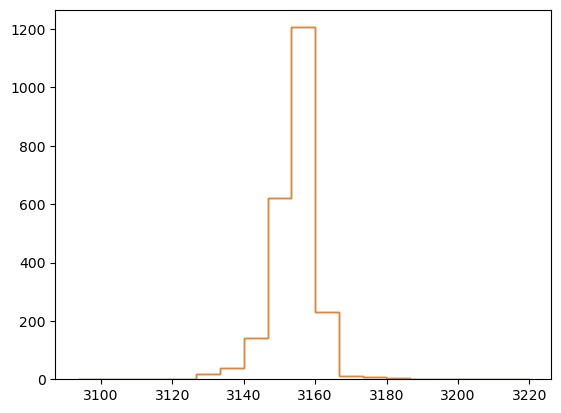

In [53]:
build_dsp(f_raw=raw_file, f_dsp=dsp_file, dsp_config=dsp_config, database=dsp_db, write_mode='r')
pk_table, _ = sto.read_object("40K", dsp_file)
plt.figure()
plt.hist(pk_table['trapEmax'].nda, bins=ebins, histtype='step')
plt.hist(pk_table['trapEmax_ctc'].nda, bins=ebins, histtype='step')

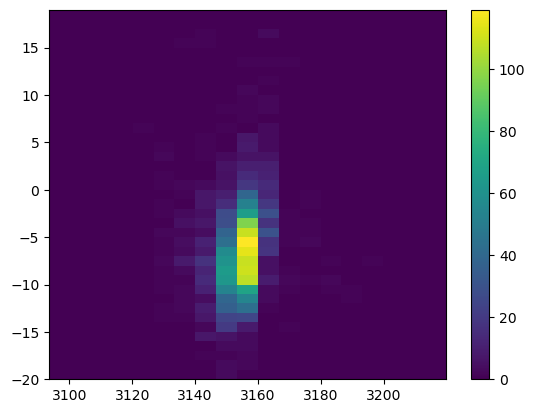

In [54]:
plt.figure()
plt.hist2d(pk_table['trapEmax'].nda, pk_table['dcr'].nda, bins=(ebins, np.arange(-20, 20)))
plt.colorbar()

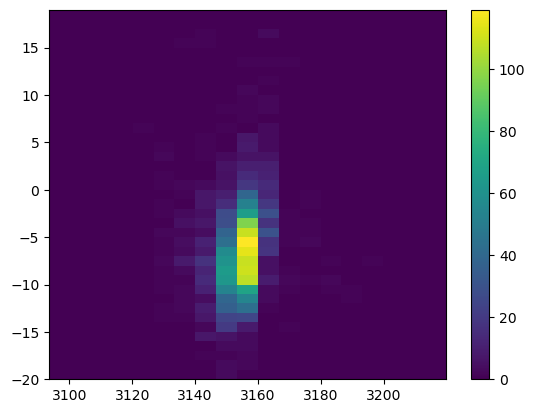

In [55]:
plt.figure()
plt.hist2d(pk_table['trapEmax_ctc'].nda, pk_table['dcr'].nda, bins=(ebins, np.arange(-20, 20)))
plt.colorbar()

# Run On One File

In [56]:
raw = fdb.df.query(f"cycle == {cyc}").iloc[0]
raw = os.path.join(fdb.data_dir, fdb.tier_dirs['raw'], raw['raw_file'])
dsp = f"cycle{cyc}_testdsp.lh5"

In [57]:
# Write results to dsp_07.json defaults
with open('./metadata/dsp/dsp_07.json') as f:
    test_config = json.load(f)
test_config['processors']['wf_pz']['defaults'] = {"db.pz.tau": dsp_db['40K']['pz']['tau']}
test_config['processors']['wf_etrap']['defaults'] = {"db.etrap.rise": dsp_db['40K']['etrap']['rise'], 
                                                  "db.etrap.flat": dsp_db['40K']['etrap']['flat']}
test_config['processors']['wf_dcr_trap']['defaults'] = {"db.dcr_trap.rise": dsp_db['40K']['dcr_trap']['rise'], 
                                                  "db.dcr_trap.flat": dsp_db['40K']['dcr_trap']['flat']}
test_config['processors']['trapEmax_ctc']['defaults'] = {"db.ctc.alpha": dsp_db['40K']['ctc']['alpha']}

In [58]:
pprint.pprint(dsp_db)

{'40K': {'ctc': {'alpha': 0.0},
         'dcr_trap': {'flat': '20.25* us', 'rise': '4.25* us'},
         'etrap': {'flat': '2*us', 'rise': '14* us'},
         'pz': {'tau': '65.66666666666667* us'}}}


In [59]:
pprint.pprint(test_config)

{'outputs': ['channel',
             'timestamp',
             'energy',
             'bl',
             'bl_sig',
             'bl_slope_ftp',
             'bl_sig',
             'bl_slope',
             'bl_intercept',
             'wf_max',
             'wf_argmax',
             'fltp',
             'fltp_sig',
             'trapEmax',
             'trapE_argmax',
             'atrap_max',
             'tp_0',
             'trapEftp',
             'trapEmax_ctc',
             'dcr',
             'dtrap_max',
             'qdrift',
             'lt_mean',
             'lt_sig',
             'lt_slope',
             'lt_int',
             'A_10',
             'AoE',
             'triE',
             'ToE',
             'tp_max',
             'tp_02',
             'tp_05',
             'tp_10',
             'tp_20',
             'tp_30',
             'tp_40',
             'tp_50',
             'tp_60',
             'tp_70',
             'tp_80',
             'tp_90',
             'tp_9

In [60]:
build_dsp(f_raw=raw, f_dsp=dsp, dsp_config=test_config, write_mode='r')

/global/u2/g/grsong/legend/pygama/src/pygama/dsp/processing_chain.py:1228: RuntimeWarning: invalid value encountered in log
  self.processor(*self.args, **self.kwargs)
Processing table ORSIS3302DecoderForEnergy/raw: 100%|██████████| 119982/119982 [03:15<00:00, 613.86 rows/s]


In [61]:
ls(dsp, 'ORSIS3302DecoderForEnergy/dsp/*')

['ORSIS3302DecoderForEnergy/dsp/A_10',
 'ORSIS3302DecoderForEnergy/dsp/AoE',
 'ORSIS3302DecoderForEnergy/dsp/ToE',
 'ORSIS3302DecoderForEnergy/dsp/atrap_max',
 'ORSIS3302DecoderForEnergy/dsp/bl',
 'ORSIS3302DecoderForEnergy/dsp/bl_intercept',
 'ORSIS3302DecoderForEnergy/dsp/bl_sig',
 'ORSIS3302DecoderForEnergy/dsp/bl_slope',
 'ORSIS3302DecoderForEnergy/dsp/bl_slope_ftp',
 'ORSIS3302DecoderForEnergy/dsp/channel',
 'ORSIS3302DecoderForEnergy/dsp/dcr',
 'ORSIS3302DecoderForEnergy/dsp/dtrap_max',
 'ORSIS3302DecoderForEnergy/dsp/energy',
 'ORSIS3302DecoderForEnergy/dsp/fltp',
 'ORSIS3302DecoderForEnergy/dsp/fltp_sig',
 'ORSIS3302DecoderForEnergy/dsp/lt_int',
 'ORSIS3302DecoderForEnergy/dsp/lt_mean',
 'ORSIS3302DecoderForEnergy/dsp/lt_sig',
 'ORSIS3302DecoderForEnergy/dsp/lt_slope',
 'ORSIS3302DecoderForEnergy/dsp/qdrift',
 'ORSIS3302DecoderForEnergy/dsp/timestamp',
 'ORSIS3302DecoderForEnergy/dsp/tp_0',
 'ORSIS3302DecoderForEnergy/dsp/tp_02',
 'ORSIS3302DecoderForEnergy/dsp/tp_05',
 'ORSIS3

In [62]:
dsp_table, _ = sto.read_object("ORSIS3302DecoderForEnergy/dsp", dsp)

(array([0., 1., 0., ..., 0., 0., 0.]),
 array([3140.        , 3140.06012024, 3140.12024048, ..., 3169.87975952,
        3169.93987976, 3170.        ]),
 <BarContainer object of 499 artists>)

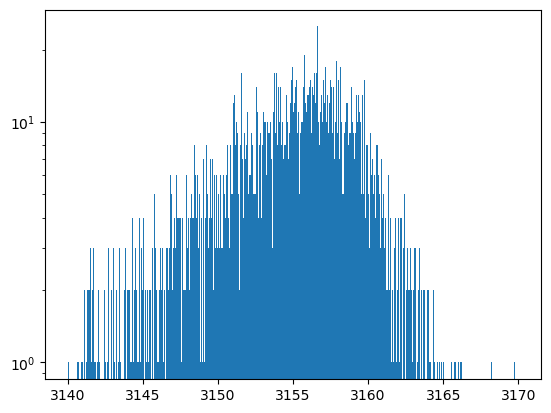

In [68]:
# energy histogram
plt.figure()
plt.yscale('log')
plt.hist(dsp_table['trapEmax'].nda, bins=np.linspace(3140, 3170, 500))

(array([0., 0., 2., ..., 0., 0., 0.]),
 array([2600.        , 2601.57894737, 2603.15789474, ..., 2626.84210526,
        2628.42105263, 2630.        ]),
 <BarContainer object of 19 artists>)

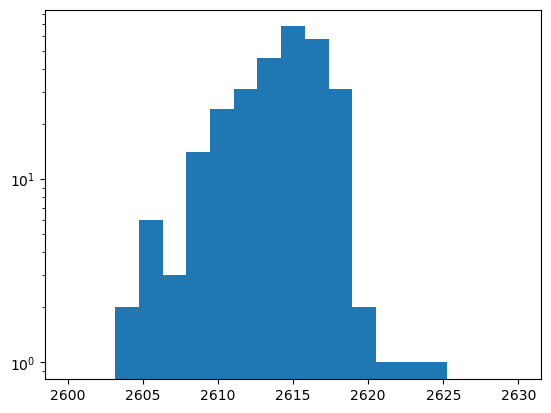

In [70]:
# check linearity
k40_peak = 3155
plt.figure()
plt.yscale('log')
plt.hist(dsp_table['trapEmax'].nda*(1460/k40_peak), bins=np.linspace(2600, 2630, 20))

(array([1., 0., 1., ..., 5., 4., 4.]),
 array([-50, -49, -48, ...,  47,  48,  49]),
 <BarContainer object of 99 artists>)

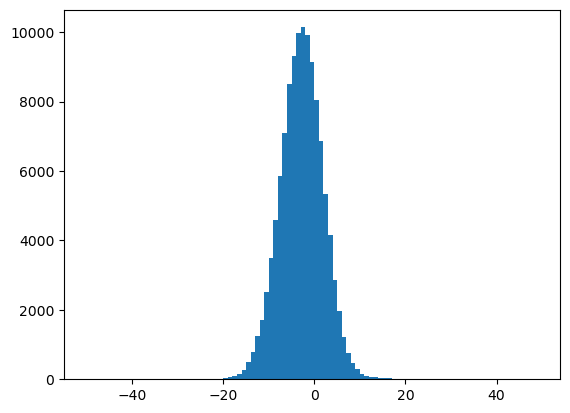

In [71]:
# dcr histogram
plt.figure()
plt.hist(dsp_table['dcr'].nda, bins=np.arange(-50, 50))

(-50.0, 50.0)

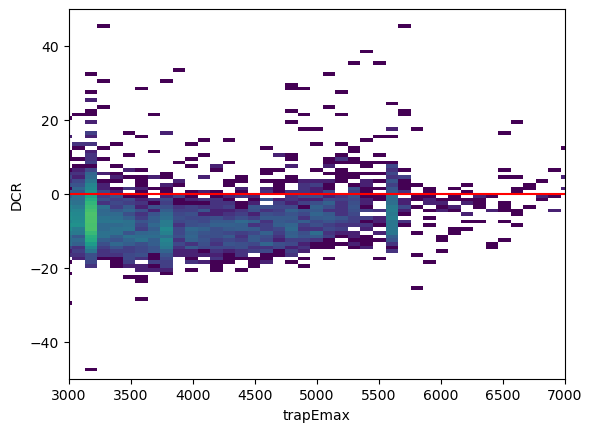

In [72]:
plt.figure()
plt.hist2d(dsp_table['trapEmax'].nda, dsp_table['dcr'].nda, 
           bins = (np.linspace(0, 10000, 100), np.arange(-200, 200)), 
           norm=colors.LogNorm())
plt.xlabel("trapEmax")
plt.ylabel("DCR")
plt.axhline(0, color='r')
plt.xlim(3000, 7000)
plt.ylim(-50, 50)

(-50.0, 50.0)

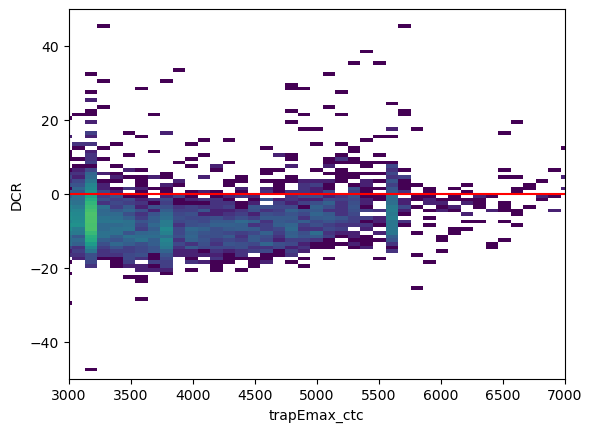

In [73]:
plt.figure()
plt.hist2d(dsp_table['trapEmax_ctc'].nda, dsp_table['dcr'].nda, 
           bins = (np.linspace(0, 10000, 100), np.arange(-200, 200)), 
           norm=colors.LogNorm())
plt.xlabel("trapEmax_ctc")
plt.ylabel("DCR")
plt.axhline(0, color='r')
plt.xlim(3000, 7000)
plt.ylim(-50, 50)

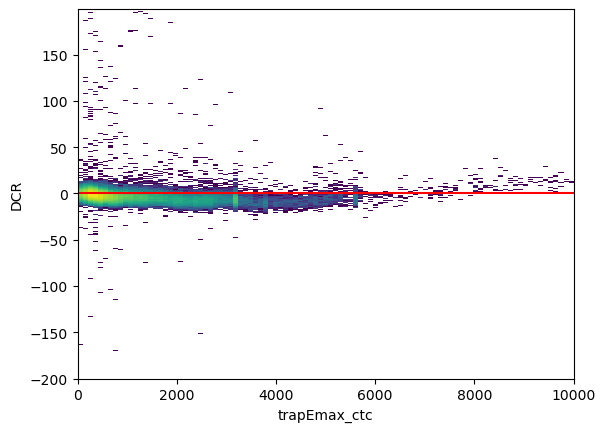

In [74]:
plt.figure()
plt.hist2d(dsp_table['trapEmax_ctc'].nda, dsp_table['dcr'].nda, 
           bins = (np.linspace(0, 10000, 100), np.arange(-200, 200)), 
           norm=colors.LogNorm())
plt.xlabel("trapEmax_ctc")
plt.ylabel("DCR")
plt.axhline(0, color='r')

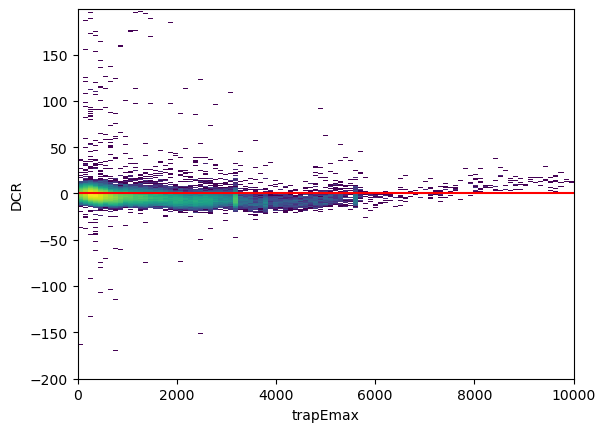

In [75]:
plt.figure()
plt.hist2d(dsp_table['trapEmax'].nda, dsp_table['dcr'].nda, 
           bins = (np.linspace(0, 10000, 100), np.arange(-200, 200)), 
           norm=colors.LogNorm())
plt.xlabel("trapEmax")
plt.ylabel("DCR")
plt.axhline(0, color='r')

(array([32., 40., 45., ..., 16., 17., 10.]),
 array([3000.        , 3010.20408163, 3020.40816327, ..., 3479.59183673,
        3489.79591837, 3500.        ]),
 [<matplotlib.patches.Polygon at 0x7f2a0f20ba30>])

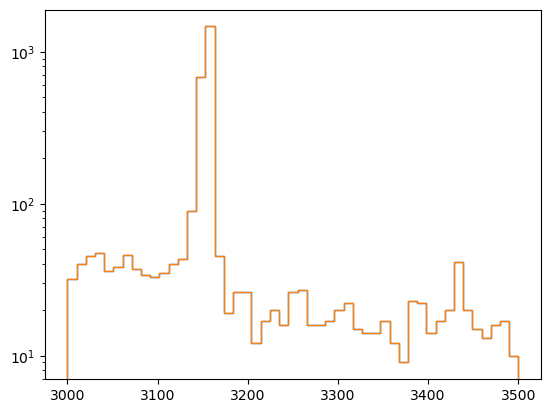

In [76]:
# energy histogram
plt.figure()
plt.yscale('log')
plt.hist(dsp_table['trapEmax'].nda, bins=np.linspace(3000, 3500, 50), histtype='step')
plt.hist(dsp_table['trapEmax_ctc'].nda, bins=np.linspace(3000, 3500, 50), histtype='step')

(array([1., 0., 2., ..., 3., 0., 0.]),
 array([5750.        , 5760.20408163, 5770.40816327, ..., 6229.59183673,
        6239.79591837, 6250.        ]),
 [<matplotlib.patches.Polygon at 0x7f2a0f14e4c0>])

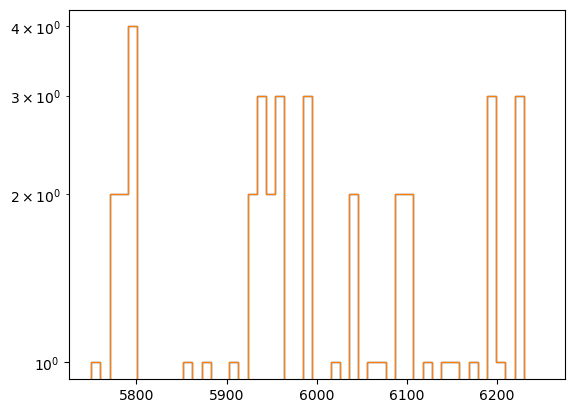

In [77]:
# energy histogram
plt.figure()
plt.yscale('log')
plt.hist(dsp_table['trapEmax'].nda, bins=np.linspace(5750, 6250, 50), histtype='step')
plt.hist(dsp_table['trapEmax_ctc'].nda, bins=np.linspace(5750, 6250, 50), histtype='step')

In [ ]:
test_config

In [78]:
# Write this configuration to a file
with open(f'./metadata/dsp/dsp_cyc{cyc}.json', 'w') as f:
    json.dump(test_config, f)